In [2]:
# import libs
import igann
import i2dgraph


import json

# import standard libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from pprint import pprint as pp  # pretty print
import os

# function to load example dataset
from sklearn.datasets import fetch_california_housing

# Load the dataset
df = pd.read_csv("./trainer-service/data/bike.csv")

In [3]:
# remap numeric features
def scale_values(values, new_min, new_max):
    if isinstance(values, (pd.Series, pd.DataFrame)):
        old_min, old_max = values.min(), values.max()
        return (values - old_min) / (old_max - old_min) * (new_max - new_min) + new_min

    arr = np.array(values)
    old_min, old_max = arr.min(), arr.max()
    return (arr - old_min) / (old_max - old_min) * (new_max - new_min) + new_min


df["Time of Day"] = df["hr"]
df["Windspeed"] = scale_values(df["windspeed"], 0, 67)
df["Temperature"] = scale_values(df["temp"], -8, 39)
df["Perceived Temperature"] = scale_values(df["atemp"], -16, 50)
df["Humidity"] = scale_values(df["hum"], 0, 100)


# remap cat features for correct categorys
# Rename season values
df["Season"] = df["season"].replace({1: "Winter", 2: "Spring", 3: "Summer", 4: "Fall"})
df["Weathersituation"] = df["weathersit"].replace(
    # {1: "Clear", 2: "Mist", 3: "Light Rain", 4: "Heavy Rain"}
    {
        1: "Clear",
        2: "Cloudy",
        3: "Light Rain",
        4: "Heavy Rain",
    }
)


# Create Day Type variable based on Working Day, Weekend, Holiday
df["Type of Day"] = np.where(
    (df["workingday"] == 1) & (df["holiday"] == 0),
    "Working Day",
    np.where((df["workingday"] == 0) & (df["holiday"] == 0), "Weekend", "Holiday"),
)


df.dropna(subset=["cnt"], inplace=True)

print(df.info())

# set correct nan
df.replace("-", np.nan, inplace=True)

# drop examples with nans
df.dropna(inplace=True)

# set X and y
y = pd.DataFrame(df["cnt"])


# drop old and not needed columns
feature_to_drop = [
    # we also drop the columns with the old names
    "dteday",
    "season",
    "yr",
    "mnth",
    "hr",
    "holiday",
    "weathersit",
    "temp",
    "atemp",
    "hum",
    "windspeed",
    "cnt",
    "instant",
    "workingday",
    "casual",
    "registered",
    "weekday",
    # also remove some renamed
    # "Temperature",
    # "Weathersituation",
    "Perceived Temperature",
    "Season",
    # "Time of Day",
    # "Type of Day",
    # "Humidity"
    # "Windspeed"
]

X = df.drop(columns=feature_to_drop, inplace=False)
print(X.shape)


print(X.describe())
print(X.info())

<class 'pandas.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   instant                17379 non-null  int64  
 1   dteday                 17379 non-null  str    
 2   season                 17379 non-null  int64  
 3   yr                     17379 non-null  int64  
 4   mnth                   17379 non-null  int64  
 5   hr                     17379 non-null  int64  
 6   holiday                17379 non-null  int64  
 7   weekday                17379 non-null  int64  
 8   workingday             17379 non-null  int64  
 9   weathersit             17379 non-null  int64  
 10  temp                   17379 non-null  float64
 11  atemp                  17379 non-null  float64
 12  hum                    17379 non-null  float64
 13  windspeed              17379 non-null  float64
 14  casual                 17379 non-null  int64  
 15  registered   

In [4]:
# very normal preprocessing
# from feature_engine.outliers import Winsorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler


# define feature types for preprocessing (also make sure to use the correct type in the datagframe)
# define cat

# this dataset has not cats
cat_features = [
    "Weathersituation",
    # "Perceived Temperature",
    # "Season",
    "Time of Day",
    "Type of Day",
    # "Humidity"
    # "Windspeed"
]

# define numeric features
num_features = [feature for feature in X.columns if feature not in cat_features]

# do some imputations

# create transformer for num features
num_Transformer = Pipeline(
    [
        (
            "num_imputer",
            SimpleImputer(strategy="mean"),
        ),
    ]
)

# create transformer for cat features
cat_Transformer = Pipeline(
    [
        # no one-hot-encoding is use here (igann does this by it self)
        (
            "cat_imputer",
            SimpleImputer(strategy="most_frequent"),
        )
    ]
)

# wrap it in CloumnTransformer
column_Transformer = ColumnTransformer(
    transformers=[
        ("num", num_Transformer, num_features),
        ("cat", cat_Transformer, cat_features),
    ],
    verbose_feature_names_out=False,
).set_output(transform="pandas")

# transform X
X = column_Transformer.fit_transform(X)
X = X.astype(
    {
        # "yr": "object",
        # "mnth": "object",
        "Time of Day": "object",
        "Type of Day": "object",
        "Weathersituation": "object",
    }
)


print(X.info())
X.describe()

<class 'pandas.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Windspeed         17379 non-null  float64
 1   Temperature       17379 non-null  float64
 2   Humidity          17379 non-null  float64
 3   Weathersituation  17379 non-null  object 
 4   Time of Day       17379 non-null  object 
 5   Type of Day       17379 non-null  object 
dtypes: float64(3), object(3)
memory usage: 814.8+ KB
None


,Windspeed,Temperature,Humidity
count,17379.000000,17379.000000,17379.000000
mean,14.971835,14.875915,62.722884
std,9.635354,9.234834,19.292983
min,0.000000,-8.000000,0.000000
25%,8.230281,7.346939,48.000000
50%,15.279182,15.020408,63.000000
75%,19.981074,22.693878,78.000000
max,67.000000,39.000000,100.000000


In [5]:
# train test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# print(X_train_reduced.shape)

In [6]:
# first normal igann
from igann import IGANN

igann = IGANN(
    task="regression",
    n_estimators=100,
    verbose=0,
    scale_y=True,
)  # 1,

igann.fit(X_train, y_train)

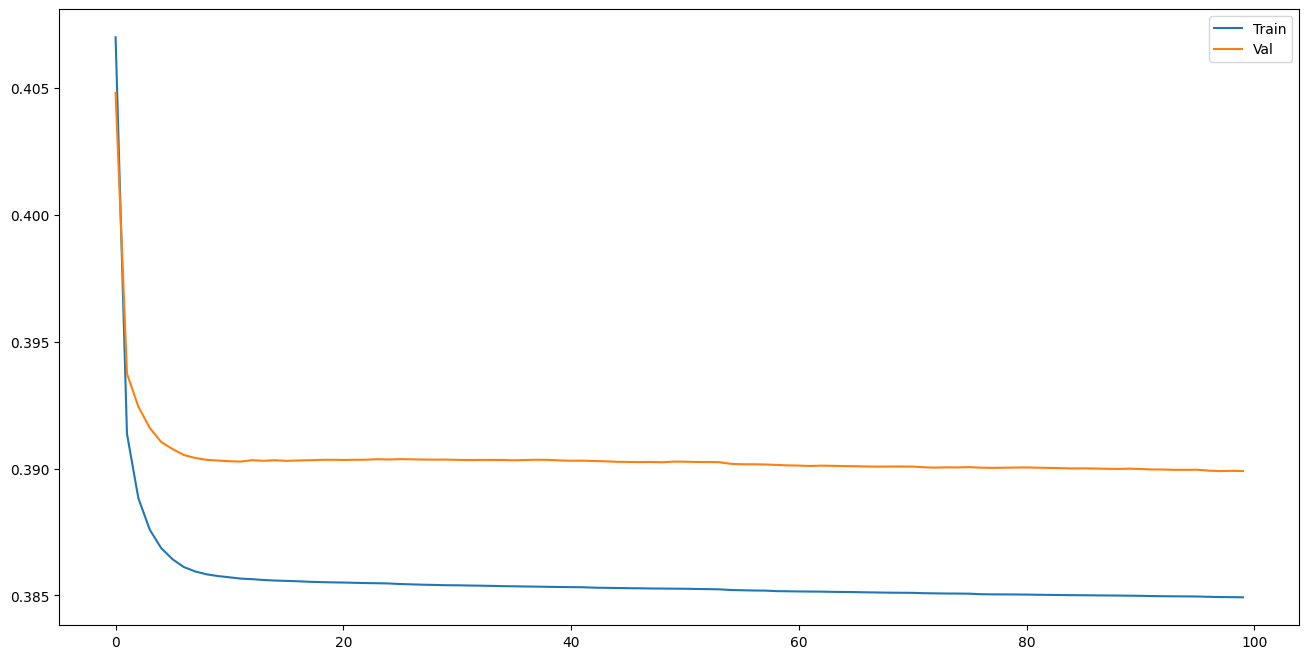

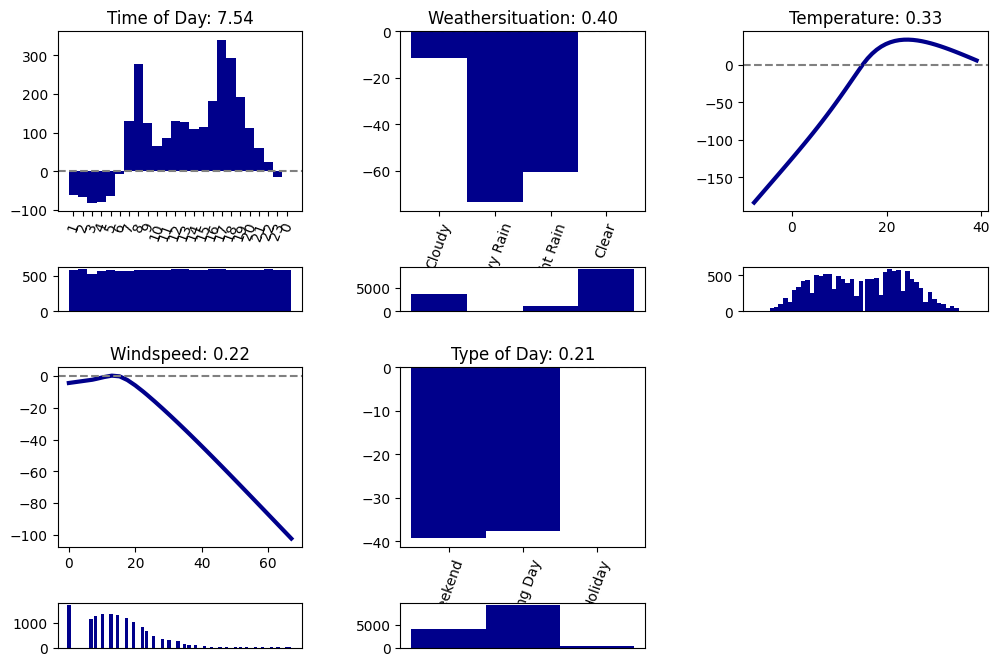

In [8]:
igann.plot_learning()
igann.plot_single()